In [1]:
import os
import sys
from datetime import datetime

import tensorflow as tf
from tensorflow import keras
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.vgg19 import VGG19
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 64 classes of optotypes. Should correspond to the folder names under images/testing and images/training
labels = ["+blank", "+circle", "+diamond", "+square", "2", "3", "5", "6", "8", "9", "apple", "bird", "C", "C-0", "C-45",
          "C-90", "C-135", "C-180", "C-225", "C-270", "C-315", "cake", "car", "circle", "cow", "cup", "D",
          "duck", "E", "E-0", "E-90", "E-180", "E-270", "F", "flat-line", "flat-square",
          "frown-line", "frown-square", "H", "hand", "horse", "house", "K", "L", "N", "O", "P",
          "panda", "phone", "R", "S", "smile-line", "smile-square", "square", "star", "T", "train",
          "tree", "V", "x-blank", "x-circle", "x-diamond", "x-square", "Z"]
img_size = 400
channels = 3
training_dir = 'drive/MyDrive/opt_images/training'
testing_dir = 'drive/MyDrive/opt_images/testing'

In [4]:
def create_datasets_test_train():
    """
    Generates two `tf.data.Dataset` from image files in the project.
    NOTE: images must be put under project root in directory images/testing and images/training
    :return: Two `tf.data.Dataset` objects, one for testing and one for training.
    """
    training_set = image_dataset_from_directory(training_dir,
                                                shuffle=True,
                                                batch_size=32,
                                                image_size=(img_size, img_size))
    testing_set = image_dataset_from_directory(testing_dir,
                                               shuffle=True,
                                               batch_size=32,
                                               image_size=(img_size, img_size))
    return training_set, testing_set

In [5]:
training_set, testing_set = create_datasets_test_train()

Found 1500 files belonging to 64 classes.
Found 3223 files belonging to 64 classes.


In [6]:
test_len = len(testing_set)

In [7]:
print(test_len)

101


### Mixing Train and Test Data (50% of test data into train, 25% of test for valid and 25% for test)

In [8]:
set1 = testing_set.take(test_len // 2)
temp = testing_set.skip(test_len // 2)
valid_set = temp.skip(test_len // 4)
testing_set = temp.take(test_len // 4)
training_set = training_set.concatenate(set1)
training_set = training_set.shuffle(buffer_size=1)

In [9]:
print(len(training_set))

97


### Trying dataset with VGG16 at different epochs, starting at 40 and increasing by 10

In [ ]:
vgg = VGG16(include_top=False, weights="imagenet", input_shape=(img_size, img_size, channels))
vgg.trainable = True
base_model = vgg

inputs = tf.keras.Input(shape=(img_size, img_size, channels))

x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = keras.layers.Flatten()(x)
X = keras.layers.Dense(128, activation='relu')(x)
X = keras.layers.Dropout(0.5)(X)
X = keras.layers.BatchNormalization()(X)

outputs = tf.keras.layers.Dense(64, activation=tf.keras.activations.softmax)(X)

model = tf.keras.Model(inputs, outputs)
model.summary()

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

58900480/58889256 [==============================] - 1s 0us/step
The following Variables were used a Lambda layer's call (tf.nn.convolution), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv1/kernel:0' shape=(3, 3, 3, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv1/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv2/kernel:0' sh

In [ ]:
model.fit(training_set, epochs=40)

Epoch 1/40
97/97 [==============================] - 181s 2s/step - loss: 4.2183 - accuracy: 0.0423
Epoch 2/40
97/97 [==============================] - 52s 534ms/step - loss: 3.5192 - accuracy: 0.1384
Epoch 3/40
97/97 [==============================] - 54s 550ms/step - loss: 3.1598 - accuracy: 0.1816
Epoch 4/40
97/97 [==============================] - 54s 547ms/step - loss: 2.8825 - accuracy: 0.2306
Epoch 5/40
97/97 [==============================] - 53s 543ms/step - loss: 2.6623 - accuracy: 0.2677
Epoch 6/40
97/97 [==============================] - 54s 553ms/step - loss: 2.4989 - accuracy: 0.3029
Epoch 7/40
97/97 [==============================] - 54s 550ms/step - loss: 2.3407 - accuracy: 0.3365
Epoch 8/40
97/97 [==============================] - 55s 564ms/step - loss: 2.2498 - accuracy: 0.3468
Epoch 9/40
97/97 [==============================] - 54s 548ms/step - loss: 2.1254 - accuracy: 0.3823
Epoch 10/40
97/97 [==============================] - 54s 555ms/step - loss: 2.0834 - accuracy

In [ ]:
model.evaluate(valid_set, verbose=1) #40

26/26 [==============================] - 104s 2s/step - loss: 1.4920 - accuracy: 0.5152


[1.4920461177825928, 0.5151883363723755]

In [ ]:
model.fit(training_set, epochs=10)

Epoch 1/10
97/97 [==============================] - 49s 498ms/step - loss: 1.4164 - accuracy: 0.5287
Epoch 2/10
97/97 [==============================] - 49s 501ms/step - loss: 1.3872 - accuracy: 0.5348
Epoch 3/10
97/97 [==============================] - 50s 504ms/step - loss: 1.3860 - accuracy: 0.5394
Epoch 4/10
97/97 [==============================] - 50s 504ms/step - loss: 1.3612 - accuracy: 0.5487
Epoch 5/10
97/97 [==============================] - 50s 506ms/step - loss: 1.3264 - accuracy: 0.5503
Epoch 6/10
97/97 [==============================] - 50s 505ms/step - loss: 1.3589 - accuracy: 0.5458
Epoch 7/10
97/97 [==============================] - 51s 519ms/step - loss: 1.3306 - accuracy: 0.5619
Epoch 8/10
97/97 [==============================] - 50s 510ms/step - loss: 1.2979 - accuracy: 0.5503
Epoch 9/10
97/97 [==============================] - 50s 507ms/step - loss: 1.3222 - accuracy: 0.5539
Epoch 10/10
97/97 [==============================] - 51s 518ms/step - loss: 1.3283 - accura

In [ ]:
model.evaluate(valid_set, verbose=1) #50

26/26 [==============================] - 20s 453ms/step - loss: 1.4385 - accuracy: 0.5043


[1.438458800315857, 0.5042527318000793]

In [ ]:
model.fit(training_set, epochs=10)

Epoch 1/10
97/97 [==============================] - 49s 498ms/step - loss: 1.2935 - accuracy: 0.5706
Epoch 2/10
97/97 [==============================] - 50s 508ms/step - loss: 1.2901 - accuracy: 0.5706
Epoch 3/10
97/97 [==============================] - 50s 505ms/step - loss: 1.2830 - accuracy: 0.5655
Epoch 4/10
97/97 [==============================] - 50s 506ms/step - loss: 1.3089 - accuracy: 0.5523
Epoch 5/10
97/97 [==============================] - 50s 507ms/step - loss: 1.3262 - accuracy: 0.5555
Epoch 6/10
97/97 [==============================] - 50s 506ms/step - loss: 1.2746 - accuracy: 0.5632
Epoch 7/10
97/97 [==============================] - 50s 506ms/step - loss: 1.2998 - accuracy: 0.5716
Epoch 8/10
97/97 [==============================] - 50s 506ms/step - loss: 1.2985 - accuracy: 0.5706
Epoch 9/10
97/97 [==============================] - 50s 507ms/step - loss: 1.2960 - accuracy: 0.5703
Epoch 10/10
97/97 [==============================] - 50s 506ms/step - loss: 1.2529 - accura

In [ ]:
model.evaluate(valid_set, verbose=1) #60

26/26 [==============================] - 20s 467ms/step - loss: 1.3998 - accuracy: 0.5298


[1.3997935056686401, 0.5297691226005554]

In [ ]:
model.fit(training_set, epochs=10)

Epoch 1/10
97/97 [==============================] - 50s 508ms/step - loss: 1.3071 - accuracy: 0.5555
Epoch 2/10
97/97 [==============================] - 50s 508ms/step - loss: 1.2660 - accuracy: 0.5639
Epoch 3/10
97/97 [==============================] - 50s 505ms/step - loss: 1.2693 - accuracy: 0.5739
Epoch 4/10
97/97 [==============================] - 50s 503ms/step - loss: 1.2409 - accuracy: 0.5835
Epoch 5/10
97/97 [==============================] - 50s 503ms/step - loss: 1.2703 - accuracy: 0.5694
Epoch 6/10
97/97 [==============================] - 50s 504ms/step - loss: 1.2671 - accuracy: 0.5652
Epoch 7/10
97/97 [==============================] - 50s 510ms/step - loss: 1.2915 - accuracy: 0.5597
Epoch 8/10
97/97 [==============================] - 50s 513ms/step - loss: 1.2586 - accuracy: 0.5684
Epoch 9/10
97/97 [==============================] - 51s 521ms/step - loss: 1.2712 - accuracy: 0.5742
Epoch 10/10
97/97 [==============================] - 52s 528ms/step - loss: 1.2178 - accura

In [ ]:
model.evaluate(valid_set, verbose=1) #70

26/26 [==============================] - 21s 471ms/step - loss: 1.3265 - accuracy: 0.5759


[1.3264529705047607, 0.5759416818618774]

In [ ]:
model.fit(training_set, epochs=10)

In [ ]:
model.evaluate(valid_set, verbose=1) #80

26/26 [==============================] - 20s 458ms/step - loss: 1.3679 - accuracy: 0.5541


[1.3678925037384033, 0.5540704727172852]

In [ ]:
model.fit(training_set, epochs=10)

Epoch 1/10
97/97 [==============================] - 49s 501ms/step - loss: 1.2576 - accuracy: 0.5739
Epoch 2/10
97/97 [==============================] - 50s 504ms/step - loss: 1.2368 - accuracy: 0.5774
Epoch 3/10
97/97 [==============================] - 50s 506ms/step - loss: 1.2547 - accuracy: 0.5684
Epoch 4/10
97/97 [==============================] - 51s 517ms/step - loss: 1.2401 - accuracy: 0.5813
Epoch 5/10
97/97 [==============================] - 52s 525ms/step - loss: 1.2132 - accuracy: 0.5819
Epoch 6/10
97/97 [==============================] - 50s 513ms/step - loss: 1.2586 - accuracy: 0.5674
Epoch 7/10
97/97 [==============================] - 50s 509ms/step - loss: 1.2208 - accuracy: 0.5787
Epoch 8/10
97/97 [==============================] - 50s 507ms/step - loss: 1.2479 - accuracy: 0.5916
Epoch 9/10
97/97 [==============================] - 50s 507ms/step - loss: 1.1972 - accuracy: 0.5910
Epoch 10/10
97/97 [==============================] - 50s 507ms/step - loss: 1.2288 - accura

In [ ]:
model.evaluate(valid_set, verbose=1) #90

26/26 [==============================] - 21s 470ms/step - loss: 1.3605 - accuracy: 0.5431


[1.3605055809020996, 0.543134868144989]

In [ ]:
model.fit(training_set, epochs=10)

Epoch 1/10
97/97 [==============================] - 49s 497ms/step - loss: 1.2360 - accuracy: 0.5794
Epoch 2/10
97/97 [==============================] - 50s 507ms/step - loss: 1.2090 - accuracy: 0.5961
Epoch 3/10
97/97 [==============================] - 50s 507ms/step - loss: 1.2370 - accuracy: 0.5739
Epoch 4/10
97/97 [==============================] - 50s 507ms/step - loss: 1.2150 - accuracy: 0.5890
Epoch 5/10
97/97 [==============================] - 50s 507ms/step - loss: 1.2028 - accuracy: 0.5932
Epoch 6/10
97/97 [==============================] - 50s 508ms/step - loss: 1.2226 - accuracy: 0.5855
Epoch 7/10
97/97 [==============================] - 50s 508ms/step - loss: 1.2049 - accuracy: 0.5861
Epoch 8/10
97/97 [==============================] - 50s 507ms/step - loss: 1.2195 - accuracy: 0.5890
Epoch 9/10
97/97 [==============================] - 50s 508ms/step - loss: 1.2065 - accuracy: 0.5797
Epoch 10/10
97/97 [==============================] - 50s 507ms/step - loss: 1.1898 - accura

In [ ]:
model.evaluate(valid_set, verbose=1) #100

26/26 [==============================] - 21s 470ms/step - loss: 1.3361 - accuracy: 0.5541


[1.3360763788223267, 0.5540704727172852]

In [ ]:
model.fit(training_set, epochs=10)

Epoch 1/10
97/97 [==============================] - 50s 510ms/step - loss: 1.1735 - accuracy: 0.5990
Epoch 2/10
97/97 [==============================] - 51s 519ms/step - loss: 1.1882 - accuracy: 0.5897
Epoch 3/10
97/97 [==============================] - 52s 527ms/step - loss: 1.1822 - accuracy: 0.5997
Epoch 4/10
97/97 [==============================] - 52s 530ms/step - loss: 1.1982 - accuracy: 0.5855
Epoch 5/10
97/97 [==============================] - 51s 516ms/step - loss: 1.1827 - accuracy: 0.5971
Epoch 6/10
97/97 [==============================] - 52s 525ms/step - loss: 1.1901 - accuracy: 0.5884
Epoch 7/10
97/97 [==============================] - 52s 530ms/step - loss: 1.1691 - accuracy: 0.6035
Epoch 8/10
97/97 [==============================] - 51s 516ms/step - loss: 1.1957 - accuracy: 0.5826
Epoch 9/10
97/97 [==============================] - 51s 518ms/step - loss: 1.1657 - accuracy: 0.6039
Epoch 10/10
97/97 [==============================] - 53s 536ms/step - loss: 1.1724 - accura

In [ ]:
model.evaluate(valid_set, verbose=1) #110

26/26 [==============================] - 21s 476ms/step - loss: 1.3689 - accuracy: 0.5371


[1.3689066171646118, 0.5370595455169678]

In [ ]:
model.fit(training_set, epochs=10)

Epoch 1/10
97/97 [==============================] - 50s 510ms/step - loss: 1.1867 - accuracy: 0.5894
Epoch 2/10
97/97 [==============================] - 50s 509ms/step - loss: 1.2367 - accuracy: 0.5784
Epoch 3/10
97/97 [==============================] - 50s 508ms/step - loss: 1.2240 - accuracy: 0.5765
Epoch 4/10
97/97 [==============================] - 50s 510ms/step - loss: 1.1556 - accuracy: 0.6055
Epoch 5/10
97/97 [==============================] - 50s 509ms/step - loss: 1.1506 - accuracy: 0.5952
Epoch 6/10
97/97 [==============================] - 50s 508ms/step - loss: 1.1686 - accuracy: 0.6023
Epoch 7/10
97/97 [==============================] - 50s 509ms/step - loss: 1.1477 - accuracy: 0.6074
Epoch 8/10
97/97 [==============================] - 51s 519ms/step - loss: 1.1569 - accuracy: 0.5919
Epoch 9/10
97/97 [==============================] - 50s 511ms/step - loss: 1.1648 - accuracy: 0.6068
Epoch 10/10
97/97 [==============================] - 50s 510ms/step - loss: 1.1716 - accura

In [ ]:
model.evaluate(valid_set, verbose=1) #120

26/26 [==============================] - 21s 480ms/step - loss: 1.3420 - accuracy: 0.5383


[1.3420027494430542, 0.5382745862007141]

In [ ]:
model.fit(training_set, epochs=10)

Epoch 1/10
97/97 [==============================] - 50s 512ms/step - loss: 1.1537 - accuracy: 0.6006
Epoch 2/10
97/97 [==============================] - 50s 509ms/step - loss: 1.1603 - accuracy: 0.6029
Epoch 3/10
97/97 [==============================] - 50s 511ms/step - loss: 1.1589 - accuracy: 0.6090
Epoch 4/10
97/97 [==============================] - 50s 511ms/step - loss: 1.1276 - accuracy: 0.6090
Epoch 5/10
97/97 [==============================] - 50s 512ms/step - loss: 1.1187 - accuracy: 0.6055
Epoch 6/10
97/97 [==============================] - 52s 525ms/step - loss: 1.1396 - accuracy: 0.6045
Epoch 7/10
97/97 [==============================] - 51s 515ms/step - loss: 1.1373 - accuracy: 0.5997
Epoch 8/10
97/97 [==============================] - 50s 512ms/step - loss: 1.1218 - accuracy: 0.6071
Epoch 9/10
97/97 [==============================] - 50s 512ms/step - loss: 1.1378 - accuracy: 0.6168
Epoch 10/10
97/97 [==============================] - 50s 509ms/step - loss: 1.1336 - accura

In [ ]:
model.evaluate(valid_set, verbose=1) #130

26/26 [==============================] - 21s 472ms/step - loss: 1.3075 - accuracy: 0.5443


[1.3074806928634644, 0.5443499684333801]

In [ ]:
model.fit(training_set, epochs=10)

Epoch 1/10
97/97 [==============================] - 50s 509ms/step - loss: 1.1428 - accuracy: 0.6106
Epoch 2/10
97/97 [==============================] - 50s 509ms/step - loss: 1.1436 - accuracy: 0.6084
Epoch 3/10
97/97 [==============================] - 50s 509ms/step - loss: 1.1216 - accuracy: 0.6113
Epoch 4/10
97/97 [==============================] - 50s 511ms/step - loss: 1.1338 - accuracy: 0.6071
Epoch 5/10
97/97 [==============================] - 50s 511ms/step - loss: 1.1247 - accuracy: 0.6061
Epoch 6/10
97/97 [==============================] - 51s 518ms/step - loss: 1.1143 - accuracy: 0.6106
Epoch 7/10
97/97 [==============================] - 51s 523ms/step - loss: 1.1046 - accuracy: 0.6161
Epoch 8/10
97/97 [==============================] - 51s 514ms/step - loss: 1.1132 - accuracy: 0.6123
Epoch 9/10
97/97 [==============================] - 51s 522ms/step - loss: 1.1646 - accuracy: 0.6026
Epoch 10/10
97/97 [==============================] - 51s 515ms/step - loss: 1.1456 - accura

In [ ]:
model.evaluate(valid_set, verbose=1) #140

26/26 [==============================] - 21s 474ms/step - loss: 1.5156 - accuracy: 0.4775


[1.5155620574951172, 0.47752127051353455]

### Restarted training and saving weights for when epoch=60

In [ ]:
model.fit(training_set, epochs=60)

Epoch 1/60
97/97 [==============================] - 53s 532ms/step - loss: 4.1598 - accuracy: 0.0452
Epoch 2/60
97/97 [==============================] - 52s 532ms/step - loss: 3.4927 - accuracy: 0.1348
Epoch 3/60
97/97 [==============================] - 51s 520ms/step - loss: 3.1485 - accuracy: 0.1932
Epoch 4/60
97/97 [==============================] - 52s 528ms/step - loss: 2.8653 - accuracy: 0.2465
Epoch 5/60
97/97 [==============================] - 52s 534ms/step - loss: 2.6344 - accuracy: 0.2890
Epoch 6/60
97/97 [==============================] - 51s 518ms/step - loss: 2.4442 - accuracy: 0.3184
Epoch 7/60
97/97 [==============================] - 52s 527ms/step - loss: 2.3280 - accuracy: 0.3390
Epoch 8/60
97/97 [==============================] - 52s 534ms/step - loss: 2.2255 - accuracy: 0.3545
Epoch 9/60
97/97 [==============================] - 52s 531ms/step - loss: 2.1057 - accuracy: 0.3871
Epoch 10/60
97/97 [==============================] - 51s 524ms/step - loss: 2.0566 - accura

In [ ]:
model.evaluate(valid_set, verbose=1) #60

26/26 [==============================] - 20s 485ms/step - loss: 1.4730 - accuracy: 0.5407


[1.472959280014038, 0.5407047271728516]

In [ ]:
import os
weights_dir = 'weights/article'
# Save model weights
model.save_weights(os.path.join(weights_dir, 'vgg16-60.h5'))

In [ ]:
weights_dir = 'drive/MyDrive/vgg16-60'
model.load_weights(os.path.join(weights_dir, 'vgg16-60.h5'))

In [ ]:
model.fit(training_set, epochs=10)

Epoch 1/10
97/97 [==============================] - 631s 6s/step - loss: 1.3573 - accuracy: 0.5500
Epoch 2/10
97/97 [==============================] - 48s 483ms/step - loss: 1.3405 - accuracy: 0.5532
Epoch 3/10
97/97 [==============================] - 48s 492ms/step - loss: 1.3113 - accuracy: 0.5681
Epoch 4/10
97/97 [==============================] - 49s 498ms/step - loss: 1.2978 - accuracy: 0.5655
Epoch 5/10
97/97 [==============================] - 49s 499ms/step - loss: 1.3037 - accuracy: 0.5658
Epoch 6/10
97/97 [==============================] - 49s 502ms/step - loss: 1.2928 - accuracy: 0.5681
Epoch 7/10
97/97 [==============================] - 49s 502ms/step - loss: 1.2854 - accuracy: 0.5613
Epoch 8/10
97/97 [==============================] - 50s 504ms/step - loss: 1.2872 - accuracy: 0.5655
Epoch 9/10
97/97 [==============================] - 50s 504ms/step - loss: 1.2916 - accuracy: 0.5706
Epoch 10/10
97/97 [==============================] - 50s 514ms/step - loss: 1.2806 - accuracy

In [ ]:
model.evaluate(testing_set, verbose=1) #70

25/25 [==============================] - 159s 6s/step - loss: 1.2517 - accuracy: 0.6100


[1.251744031906128, 0.6100000143051147]

### Trying VGG19 with new dataset with different epochs, starting at 40 and increasing by 10

In [ ]:
vgg = VGG19(include_top=False, weights="imagenet", input_shape=(img_size, img_size, channels))
vgg.trainable = True
base_model = vgg

inputs = tf.keras.Input(shape=(img_size, img_size, channels))

x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = keras.layers.Flatten()(x)
X = keras.layers.Dense(128, activation='relu')(x)
X = keras.layers.Dropout(0.5)(X)
X = keras.layers.BatchNormalization()(X)

outputs = tf.keras.layers.Dense(64, activation=tf.keras.activations.softmax)(X)

model = tf.keras.Model(inputs, outputs)
model.summary()

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

80150528/80134624 [==============================] - 1s 0us/step
The following Variables were used a Lambda layer's call (tf.nn.convolution_13), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv1/kernel:0' shape=(3, 3, 3, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_13), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv1/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_14), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv2/kerne

In [ ]:
model.fit(training_set, epochs=60)

Epoch 1/60
97/97 [==============================] - 58s 585ms/step - loss: 4.1802 - accuracy: 0.0477
Epoch 2/60
97/97 [==============================] - 61s 622ms/step - loss: 3.4836 - accuracy: 0.1413
Epoch 3/60
97/97 [==============================] - 64s 651ms/step - loss: 3.1175 - accuracy: 0.1994
Epoch 4/60
97/97 [==============================] - 64s 655ms/step - loss: 2.8433 - accuracy: 0.2506
Epoch 5/60
97/97 [==============================] - 63s 640ms/step - loss: 2.6060 - accuracy: 0.2832
Epoch 6/60
97/97 [==============================] - 64s 658ms/step - loss: 2.4311 - accuracy: 0.3229
Epoch 7/60
97/97 [==============================] - 63s 643ms/step - loss: 2.2722 - accuracy: 0.3365
Epoch 8/60
97/97 [==============================] - 64s 658ms/step - loss: 2.1659 - accuracy: 0.3671
Epoch 9/60
97/97 [==============================] - 64s 656ms/step - loss: 2.0530 - accuracy: 0.3926
Epoch 10/60
97/97 [==============================] - 63s 640ms/step - loss: 1.9796 - accura

In [ ]:
model.evaluate(valid_set, verbose=1) #60

26/26 [==============================] - 23s 563ms/step - loss: 1.1785 - accuracy: 0.5759


[1.1785175800323486, 0.5759416818618774]

In [ ]:
model.fit(training_set, epochs=10)

Epoch 1/10
97/97 [==============================] - 60s 608ms/step - loss: 1.1226 - accuracy: 0.6065
Epoch 2/10
97/97 [==============================] - 60s 614ms/step - loss: 1.1586 - accuracy: 0.5929
Epoch 3/10
97/97 [==============================] - 60s 609ms/step - loss: 1.1777 - accuracy: 0.5971
Epoch 4/10
97/97 [==============================] - 60s 615ms/step - loss: 1.1888 - accuracy: 0.5919
Epoch 5/10
97/97 [==============================] - 60s 610ms/step - loss: 1.1769 - accuracy: 0.5910
Epoch 6/10
97/97 [==============================] - 60s 608ms/step - loss: 1.1620 - accuracy: 0.5965
Epoch 7/10
97/97 [==============================] - 60s 606ms/step - loss: 1.1361 - accuracy: 0.6026
Epoch 8/10
97/97 [==============================] - 59s 605ms/step - loss: 1.1452 - accuracy: 0.6065
Epoch 9/10
97/97 [==============================] - 60s 608ms/step - loss: 1.1485 - accuracy: 0.6184
Epoch 10/10
97/97 [==============================] - 59s 606ms/step - loss: 1.1505 - accura

In [ ]:
model.evaluate(valid_set, verbose=1) #70

26/26 [==============================] - 23s 561ms/step - loss: 1.2092 - accuracy: 0.5687


[1.20916748046875, 0.5686512589454651]

In [ ]:
model.fit(training_set, epochs=10)

Epoch 1/10
97/97 [==============================] - 59s 606ms/step - loss: 1.1724 - accuracy: 0.5948
Epoch 2/10
97/97 [==============================] - 59s 605ms/step - loss: 1.1292 - accuracy: 0.6058
Epoch 3/10
97/97 [==============================] - 59s 604ms/step - loss: 1.1752 - accuracy: 0.5984
Epoch 4/10
97/97 [==============================] - 59s 604ms/step - loss: 1.1414 - accuracy: 0.6000
Epoch 5/10
97/97 [==============================] - 59s 604ms/step - loss: 1.1297 - accuracy: 0.6081
Epoch 6/10
97/97 [==============================] - 59s 605ms/step - loss: 1.0904 - accuracy: 0.6229
Epoch 7/10
97/97 [==============================] - 59s 605ms/step - loss: 1.0984 - accuracy: 0.6187
Epoch 8/10
97/97 [==============================] - 60s 611ms/step - loss: 1.0679 - accuracy: 0.6252
Epoch 9/10
97/97 [==============================] - 60s 608ms/step - loss: 1.1057 - accuracy: 0.6197
Epoch 10/10
97/97 [==============================] - 60s 608ms/step - loss: 1.0903 - accura

In [ ]:
model.evaluate(valid_set, verbose=1) #80

26/26 [==============================] - 23s 572ms/step - loss: 1.1415 - accuracy: 0.5881


[1.141545057296753, 0.5880923271179199]

In [ ]:
model.fit(training_set, epochs=10)

Epoch 1/10
97/97 [==============================] - 60s 607ms/step - loss: 1.0704 - accuracy: 0.6261
Epoch 2/10
97/97 [==============================] - 60s 607ms/step - loss: 1.1191 - accuracy: 0.6068
Epoch 3/10
97/97 [==============================] - 60s 613ms/step - loss: 1.0844 - accuracy: 0.6274
Epoch 4/10
97/97 [==============================] - 60s 611ms/step - loss: 1.0822 - accuracy: 0.6168
Epoch 5/10
97/97 [==============================] - 60s 609ms/step - loss: 1.0956 - accuracy: 0.6158
Epoch 6/10
97/97 [==============================] - 60s 614ms/step - loss: 1.1242 - accuracy: 0.6184
Epoch 7/10
97/97 [==============================] - 60s 613ms/step - loss: 1.0831 - accuracy: 0.6203
Epoch 8/10
97/97 [==============================] - 60s 611ms/step - loss: 1.0960 - accuracy: 0.6203
Epoch 9/10
97/97 [==============================] - 60s 616ms/step - loss: 1.0612 - accuracy: 0.6248
Epoch 10/10
97/97 [==============================] - 60s 613ms/step - loss: 1.1343 - accura

In [ ]:
model.evaluate(valid_set, verbose=1) #90

26/26 [==============================] - 23s 567ms/step - loss: 1.1658 - accuracy: 0.5820


[1.1657918691635132, 0.5820170044898987]

In [ ]:
model.fit(training_set, epochs=10)

Epoch 1/10
97/97 [==============================] - 61s 623ms/step - loss: 1.0934 - accuracy: 0.6245
Epoch 2/10
97/97 [==============================] - 59s 607ms/step - loss: 1.1083 - accuracy: 0.6045
Epoch 3/10
97/97 [==============================] - 61s 622ms/step - loss: 1.0884 - accuracy: 0.6294
Epoch 4/10
97/97 [==============================] - 60s 608ms/step - loss: 1.0667 - accuracy: 0.6248
Epoch 5/10
97/97 [==============================] - 61s 622ms/step - loss: 1.0718 - accuracy: 0.6245
Epoch 6/10
97/97 [==============================] - 60s 612ms/step - loss: 1.0594 - accuracy: 0.6206
Epoch 7/10
97/97 [==============================] - 60s 612ms/step - loss: 1.0427 - accuracy: 0.6368
Epoch 8/10
97/97 [==============================] - 61s 621ms/step - loss: 1.0639 - accuracy: 0.6210
Epoch 9/10
97/97 [==============================] - 61s 618ms/step - loss: 1.0790 - accuracy: 0.6139
Epoch 10/10
97/97 [==============================] - 61s 620ms/step - loss: 1.1128 - accura

In [ ]:
model.evaluate(valid_set, verbose=1) #100

26/26 [==============================] - 209s 4s/step - loss: 1.1471 - accuracy: 0.6015


[1.147148609161377, 0.6014580726623535]

In [ ]:
model.fit(training_set, epochs=10)

Epoch 1/10
97/97 [==============================] - 61s 627ms/step - loss: 1.0404 - accuracy: 0.6277
Epoch 2/10
97/97 [==============================] - 60s 610ms/step - loss: 1.0594 - accuracy: 0.6271
Epoch 3/10
97/97 [==============================] - 61s 626ms/step - loss: 1.0705 - accuracy: 0.6274
Epoch 4/10
97/97 [==============================] - 61s 622ms/step - loss: 1.0377 - accuracy: 0.6416
Epoch 5/10
97/97 [==============================] - 60s 611ms/step - loss: 1.0765 - accuracy: 0.6258
Epoch 6/10
97/97 [==============================] - 60s 615ms/step - loss: 1.0514 - accuracy: 0.6190
Epoch 7/10
97/97 [==============================] - 60s 615ms/step - loss: 0.9936 - accuracy: 0.6523
Epoch 8/10
97/97 [==============================] - 61s 623ms/step - loss: 1.0193 - accuracy: 0.6387
Epoch 9/10
97/97 [==============================] - 60s 610ms/step - loss: 1.0157 - accuracy: 0.6452
Epoch 10/10
97/97 [==============================] - 61s 624ms/step - loss: 1.0777 - accura

In [ ]:
model.evaluate(valid_set, verbose=1) #110

26/26 [==============================] - 23s 587ms/step - loss: 1.2127 - accuracy: 0.6015


[1.2127381563186646, 0.6014580726623535]

In [ ]:
model.fit(training_set, epochs=10)

Epoch 1/10
97/97 [==============================] - 61s 622ms/step - loss: 1.0577 - accuracy: 0.6235
Epoch 2/10
97/97 [==============================] - 60s 616ms/step - loss: 1.0439 - accuracy: 0.6332
Epoch 3/10
97/97 [==============================] - 62s 629ms/step - loss: 1.0585 - accuracy: 0.6206
Epoch 4/10
97/97 [==============================] - 62s 629ms/step - loss: 1.0308 - accuracy: 0.6310
Epoch 5/10
97/97 [==============================] - 62s 628ms/step - loss: 1.0187 - accuracy: 0.6494
Epoch 6/10
97/97 [==============================] - 61s 624ms/step - loss: 1.0132 - accuracy: 0.6342
Epoch 7/10
97/97 [==============================] - 60s 613ms/step - loss: 1.0464 - accuracy: 0.6342
Epoch 8/10
97/97 [==============================] - 60s 616ms/step - loss: 1.0389 - accuracy: 0.6348
Epoch 9/10
97/97 [==============================] - 61s 624ms/step - loss: 1.0289 - accuracy: 0.6365
Epoch 10/10
97/97 [==============================] - 61s 623ms/step - loss: 1.0259 - accura

In [ ]:
model.evaluate(valid_set, verbose=1) #120

26/26 [==============================] - 24s 608ms/step - loss: 1.1569 - accuracy: 0.6173


[1.1569312810897827, 0.6172539591789246]

In [ ]:
model.fit(training_set, epochs=10)

Epoch 1/10
97/97 [==============================] - 61s 622ms/step - loss: 1.0217 - accuracy: 0.6410
Epoch 2/10
97/97 [==============================] - 61s 623ms/step - loss: 1.0234 - accuracy: 0.6374
Epoch 3/10
97/97 [==============================] - 61s 626ms/step - loss: 1.0186 - accuracy: 0.6400
Epoch 4/10
97/97 [==============================] - 61s 622ms/step - loss: 1.0220 - accuracy: 0.6432
Epoch 5/10
97/97 [==============================] - 61s 621ms/step - loss: 1.0335 - accuracy: 0.6348
Epoch 6/10
97/97 [==============================] - 61s 625ms/step - loss: 1.0158 - accuracy: 0.6358
Epoch 7/10
97/97 [==============================] - 61s 625ms/step - loss: 1.0046 - accuracy: 0.6384
Epoch 8/10
97/97 [==============================] - 61s 625ms/step - loss: 1.0060 - accuracy: 0.6384
Epoch 9/10
97/97 [==============================] - 61s 626ms/step - loss: 0.9592 - accuracy: 0.6626
Epoch 10/10
97/97 [==============================] - 61s 623ms/step - loss: 1.0452 - accura

In [ ]:
model.evaluate(valid_set, verbose=1) #130

26/26 [==============================] - 23s 593ms/step - loss: 1.1954 - accuracy: 0.5978


[1.195421814918518, 0.5978128910064697]

In [ ]:
model.fit(training_set, epochs=10)

Epoch 1/10
97/97 [==============================] - 61s 622ms/step - loss: 1.0312 - accuracy: 0.6261
Epoch 2/10
97/97 [==============================] - 61s 625ms/step - loss: 0.9899 - accuracy: 0.6526
Epoch 3/10
97/97 [==============================] - 61s 624ms/step - loss: 1.0200 - accuracy: 0.6319
Epoch 4/10
97/97 [==============================] - 61s 623ms/step - loss: 1.0061 - accuracy: 0.6423
Epoch 5/10
97/97 [==============================] - 61s 623ms/step - loss: 1.0194 - accuracy: 0.6429
Epoch 6/10
97/97 [==============================] - 60s 609ms/step - loss: 1.0397 - accuracy: 0.6323
Epoch 7/10
97/97 [==============================] - 61s 625ms/step - loss: 1.0176 - accuracy: 0.6400
Epoch 8/10
97/97 [==============================] - 61s 623ms/step - loss: 1.0223 - accuracy: 0.6300
Epoch 9/10
97/97 [==============================] - 60s 610ms/step - loss: 1.0086 - accuracy: 0.6390
Epoch 10/10
97/97 [==============================] - 61s 626ms/step - loss: 0.9981 - accura

In [ ]:
model.evaluate(valid_set, verbose=1) #140

26/26 [==============================] - 23s 588ms/step - loss: 1.1591 - accuracy: 0.6245


[1.1591356992721558, 0.6245443224906921]

In [ ]:
model.fit(training_set, epochs=10)

Epoch 1/10
97/97 [==============================] - 61s 626ms/step - loss: 1.0066 - accuracy: 0.6423
Epoch 2/10
97/97 [==============================] - 61s 623ms/step - loss: 1.0178 - accuracy: 0.6400
Epoch 3/10
97/97 [==============================] - 61s 622ms/step - loss: 1.0321 - accuracy: 0.6426
Epoch 4/10
97/97 [==============================] - 61s 624ms/step - loss: 0.9907 - accuracy: 0.6423
Epoch 5/10
97/97 [==============================] - 60s 610ms/step - loss: 0.9937 - accuracy: 0.6448
Epoch 6/10
97/97 [==============================] - 60s 615ms/step - loss: 1.0253 - accuracy: 0.6413
Epoch 7/10
97/97 [==============================] - 61s 624ms/step - loss: 1.0140 - accuracy: 0.6384
Epoch 8/10
97/97 [==============================] - 61s 624ms/step - loss: 0.9645 - accuracy: 0.6497
Epoch 9/10
97/97 [==============================] - 61s 622ms/step - loss: 0.9826 - accuracy: 0.6494
Epoch 10/10
97/97 [==============================] - 61s 622ms/step - loss: 0.9429 - accura

In [ ]:
model.evaluate(valid_set, verbose=1) #150 

26/26 [==============================] - 23s 572ms/step - loss: 1.1326 - accuracy: 0.6185


[1.1325528621673584, 0.6184689998626709]

In [ ]:
model.fit(training_set, epochs=10)

Epoch 1/10
97/97 [==============================] - 61s 623ms/step - loss: 1.0061 - accuracy: 0.6403
Epoch 2/10
97/97 [==============================] - 60s 614ms/step - loss: 0.9705 - accuracy: 0.6590
Epoch 3/10
97/97 [==============================] - 61s 623ms/step - loss: 0.9666 - accuracy: 0.6497
Epoch 4/10
97/97 [==============================] - 60s 610ms/step - loss: 0.9532 - accuracy: 0.6652
Epoch 5/10
97/97 [==============================] - 61s 625ms/step - loss: 0.9702 - accuracy: 0.6581
Epoch 6/10
97/97 [==============================] - 61s 622ms/step - loss: 0.9783 - accuracy: 0.6574
Epoch 7/10
97/97 [==============================] - 60s 608ms/step - loss: 0.9711 - accuracy: 0.6529
Epoch 8/10
97/97 [==============================] - 61s 626ms/step - loss: 0.9372 - accuracy: 0.6642
Epoch 9/10
97/97 [==============================] - 61s 621ms/step - loss: 0.9700 - accuracy: 0.6555
Epoch 10/10
97/97 [==============================] - 61s 623ms/step - loss: 0.9686 - accura

In [ ]:
model.evaluate(valid_set, verbose=1) #160

26/26 [==============================] - 23s 581ms/step - loss: 1.1017 - accuracy: 0.6330


[1.1016980409622192, 0.6330498456954956]

In [ ]:
model.fit(training_set, epochs=10)

Epoch 1/10
97/97 [==============================] - 61s 623ms/step - loss: 0.9562 - accuracy: 0.6458
Epoch 2/10
97/97 [==============================] - 61s 621ms/step - loss: 1.0023 - accuracy: 0.6471
Epoch 3/10
97/97 [==============================] - 60s 611ms/step - loss: 0.9261 - accuracy: 0.6648
Epoch 4/10
97/97 [==============================] - 60s 614ms/step - loss: 0.9480 - accuracy: 0.6587
Epoch 5/10
97/97 [==============================] - 62s 629ms/step - loss: 0.9745 - accuracy: 0.6523
Epoch 6/10
97/97 [==============================] - 60s 613ms/step - loss: 0.9613 - accuracy: 0.6568
Epoch 7/10
97/97 [==============================] - 60s 612ms/step - loss: 0.9335 - accuracy: 0.6768
Epoch 8/10
97/97 [==============================] - 60s 615ms/step - loss: 0.9406 - accuracy: 0.6632
Epoch 9/10
97/97 [==============================] - 61s 625ms/step - loss: 0.9632 - accuracy: 0.6561
Epoch 10/10
97/97 [==============================] - 61s 624ms/step - loss: 0.9651 - accura

In [ ]:
model.evaluate(valid_set, verbose=1) #170

26/26 [==============================] - 24s 606ms/step - loss: 1.0601 - accuracy: 0.6209


[1.0600800514221191, 0.6208991408348083]

In [ ]:
model.fit(training_set, epochs=10)

Epoch 1/10
97/97 [==============================] - 61s 627ms/step - loss: 0.9185 - accuracy: 0.6590
Epoch 2/10
97/97 [==============================] - 61s 623ms/step - loss: 0.9511 - accuracy: 0.6613
Epoch 3/10
97/97 [==============================] - 61s 622ms/step - loss: 0.9628 - accuracy: 0.6516
Epoch 4/10
97/97 [==============================] - 60s 609ms/step - loss: 0.9738 - accuracy: 0.6671
Epoch 5/10
97/97 [==============================] - 61s 624ms/step - loss: 0.9531 - accuracy: 0.6587
Epoch 6/10
97/97 [==============================] - 61s 623ms/step - loss: 0.9343 - accuracy: 0.6574
Epoch 7/10
97/97 [==============================] - 61s 621ms/step - loss: 0.9770 - accuracy: 0.6497
Epoch 8/10
97/97 [==============================] - 61s 622ms/step - loss: 0.9285 - accuracy: 0.6500
Epoch 9/10
97/97 [==============================] - 60s 610ms/step - loss: 0.9413 - accuracy: 0.6565
Epoch 10/10
97/97 [==============================] - 60s 614ms/step - loss: 0.9548 - accura

In [ ]:
model.evaluate(valid_set, verbose=1) #180

26/26 [==============================] - 23s 588ms/step - loss: 1.1084 - accuracy: 0.6136


[1.1083630323410034, 0.6136087775230408]

In [ ]:
model.fit(training_set, epochs=10)

Epoch 1/10
97/97 [==============================] - 61s 624ms/step - loss: 0.9490 - accuracy: 0.6577
Epoch 2/10
97/97 [==============================] - 61s 622ms/step - loss: 0.9245 - accuracy: 0.6577
Epoch 3/10
97/97 [==============================] - 60s 611ms/step - loss: 0.9550 - accuracy: 0.6587
Epoch 4/10
97/97 [==============================] - 61s 626ms/step - loss: 0.9680 - accuracy: 0.6571
Epoch 5/10
97/97 [==============================] - 61s 625ms/step - loss: 0.9288 - accuracy: 0.6703
Epoch 6/10
97/97 [==============================] - 60s 611ms/step - loss: 0.9377 - accuracy: 0.6623
Epoch 7/10
97/97 [==============================] - 61s 624ms/step - loss: 0.9421 - accuracy: 0.6619
Epoch 8/10
97/97 [==============================] - 61s 621ms/step - loss: 0.9417 - accuracy: 0.6745
Epoch 9/10
97/97 [==============================] - 61s 624ms/step - loss: 0.9352 - accuracy: 0.6694
Epoch 10/10
97/97 [==============================] - 61s 621ms/step - loss: 0.9645 - accura

In [ ]:
model.evaluate(valid_set, verbose=1) #180

26/26 [==============================] - 23s 581ms/step - loss: 1.1066 - accuracy: 0.6124


[1.1065982580184937, 0.6123936772346497]

In [ ]:
model.fit(training_set, epochs=10)

Epoch 1/10
97/97 [==============================] - 60s 614ms/step - loss: 0.9653 - accuracy: 0.6552
Epoch 2/10
97/97 [==============================] - 61s 624ms/step - loss: 0.9329 - accuracy: 0.6652
Epoch 3/10
97/97 [==============================] - 60s 611ms/step - loss: 0.9343 - accuracy: 0.6600
Epoch 4/10
97/97 [==============================] - 60s 616ms/step - loss: 0.9330 - accuracy: 0.6697
Epoch 5/10
97/97 [==============================] - 61s 619ms/step - loss: 0.9603 - accuracy: 0.6642
Epoch 6/10
97/97 [==============================] - 61s 625ms/step - loss: 0.9567 - accuracy: 0.6594
Epoch 7/10
97/97 [==============================] - 61s 625ms/step - loss: 0.9265 - accuracy: 0.6623
Epoch 8/10
97/97 [==============================] - 60s 611ms/step - loss: 0.9552 - accuracy: 0.6635
Epoch 9/10
97/97 [==============================] - 60s 616ms/step - loss: 0.9344 - accuracy: 0.6716
Epoch 10/10
97/97 [==============================] - 61s 627ms/step - loss: 0.9495 - accura

In [ ]:
model.evaluate(valid_set, verbose=1) #190

26/26 [==============================] - 23s 592ms/step - loss: 1.1400 - accuracy: 0.6100


[1.1399586200714111, 0.6099635362625122]

In [ ]:
import os
weights_dir = 'weights/article'
# Save model weights
model.save_weights(os.path.join(weights_dir, 'vgg19-180'))

In [ ]:
model.fit(training_set, epochs=80)

Epoch 1/80
97/97 [==============================] - 534s 5s/step - loss: 4.2084 - accuracy: 0.0477
Epoch 2/80
97/97 [==============================] - 55s 562ms/step - loss: 3.4617 - accuracy: 0.1423
Epoch 3/80
97/97 [==============================] - 56s 570ms/step - loss: 3.0599 - accuracy: 0.2068
Epoch 4/80
97/97 [==============================] - 56s 574ms/step - loss: 2.7859 - accuracy: 0.2548
Epoch 5/80
97/97 [==============================] - 57s 585ms/step - loss: 2.5130 - accuracy: 0.3000
Epoch 6/80
97/97 [==============================] - 57s 581ms/step - loss: 2.3666 - accuracy: 0.3261
Epoch 7/80
97/97 [==============================] - 58s 590ms/step - loss: 2.2258 - accuracy: 0.3542
Epoch 8/80
97/97 [==============================] - 58s 597ms/step - loss: 2.1170 - accuracy: 0.3832
Epoch 9/80
97/97 [==============================] - 57s 584ms/step - loss: 2.0196 - accuracy: 0.3897
Epoch 10/80
97/97 [==============================] - 58s 593ms/step - loss: 1.9206 - accuracy

In [ ]:
weights_dir = 'drive/MyDrive/160'
model.load_weights(os.path.join(weights_dir, 'vgg19-160.h5'))

In [ ]:
model.evaluate(testing_set, verbose=1) #160

25/25 [==============================] - 20s 562ms/step - loss: 0.8253 - accuracy: 0.7525


[0.8252878785133362, 0.7524999976158142]

### VGG-16 Freeze all layers

In [ ]:
vgg = VGG16(include_top=False, weights="imagenet", input_shape=(img_size, img_size, channels))
vgg.trainable = True
base_model = vgg

# freeze layers
for layer in base_model.layers[:]:
    layer.trainable = False


inputs = tf.keras.Input(shape=(img_size, img_size, channels))

x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = keras.layers.Flatten()(x)
X = keras.layers.Dense(128, activation='relu')(x)
X = keras.layers.Dropout(0.5)(X)
X = keras.layers.BatchNormalization()(X)

outputs = tf.keras.layers.Dense(64, activation=tf.keras.activations.softmax)(X)

model = tf.keras.Model(inputs, outputs)
model.summary()

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

The following Variables were used a Lambda layer's call (tf.nn.convolution_29), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv1/kernel:0' shape=(3, 3, 3, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_29), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv1/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_30), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv2/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this

In [ ]:
model.fit(training_set, epochs=70)

Epoch 1/70
97/97 [==============================] - 48s 484ms/step - loss: 4.2183 - accuracy: 0.0484
Epoch 2/70
97/97 [==============================] - 48s 492ms/step - loss: 3.5286 - accuracy: 0.1300
Epoch 3/70
97/97 [==============================] - 49s 496ms/step - loss: 3.1739 - accuracy: 0.1887
Epoch 4/70
97/97 [==============================] - 50s 505ms/step - loss: 2.9180 - accuracy: 0.2306
Epoch 5/70
97/97 [==============================] - 49s 501ms/step - loss: 2.7090 - accuracy: 0.2652
Epoch 6/70
97/97 [==============================] - 50s 512ms/step - loss: 2.5071 - accuracy: 0.2984
Epoch 7/70
97/97 [==============================] - 50s 507ms/step - loss: 2.4083 - accuracy: 0.3181
Epoch 8/70
97/97 [==============================] - 49s 502ms/step - loss: 2.2937 - accuracy: 0.3365
Epoch 9/70
97/97 [==============================] - 49s 501ms/step - loss: 2.1672 - accuracy: 0.3684
Epoch 10/70
97/97 [==============================] - 49s 498ms/step - loss: 2.0847 - accura

In [ ]:
model.evaluate(valid_set, verbose=1) #160

26/26 [==============================] - 123s 4s/step - loss: 1.3869 - accuracy: 0.5140


[1.3868820667266846, 0.5139732956886292]

In [ ]:
model.evaluate(testing_set, verbose=1) #160

25/25 [==============================] - 18s 522ms/step - loss: 1.3781 - accuracy: 0.5437


[1.3781497478485107, 0.543749988079071]

In [ ]:
import os
weights_dir = 'weights/article'
# Save model weights
model.save_weights(os.path.join(weights_dir, 'vgg16-froze.h5'))

### VGG-16 Freeze half of the layers

In [ ]:
vgg = VGG16(include_top=False, weights="imagenet", input_shape=(img_size, img_size, channels))
vgg.trainable = True
base_model = vgg

len = len(base_model.layers) // 2

# freeze layers
for layer in base_model.layers[:len]:
    layer.trainable = False


inputs = tf.keras.Input(shape=(img_size, img_size, channels))

x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = keras.layers.Flatten()(x)
X = keras.layers.Dense(128, activation='relu')(x)
X = keras.layers.Dropout(0.5)(X)
X = keras.layers.BatchNormalization()(X)

outputs = tf.keras.layers.Dense(64, activation=tf.keras.activations.softmax)(X)

model = tf.keras.Model(inputs, outputs)
model.summary()

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

The following Variables were used a Lambda layer's call (tf.nn.convolution_42), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv1/kernel:0' shape=(3, 3, 3, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_42), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv1/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_43), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv2/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this

In [ ]:
model.fit(training_set, epochs=70)

Epoch 1/70
97/97 [==============================] - 51s 517ms/step - loss: 4.1919 - accuracy: 0.0468
Epoch 2/70
97/97 [==============================] - 51s 516ms/step - loss: 3.5439 - accuracy: 0.1252
Epoch 3/70
97/97 [==============================] - 51s 519ms/step - loss: 3.1411 - accuracy: 0.1871
Epoch 4/70
97/97 [==============================] - 51s 516ms/step - loss: 2.8582 - accuracy: 0.2355
Epoch 5/70
97/97 [==============================] - 51s 518ms/step - loss: 2.6655 - accuracy: 0.2713
Epoch 6/70
97/97 [==============================] - 51s 517ms/step - loss: 2.5038 - accuracy: 0.2997
Epoch 7/70
97/97 [==============================] - 50s 509ms/step - loss: 2.3625 - accuracy: 0.3303
Epoch 8/70
97/97 [==============================] - 49s 501ms/step - loss: 2.2594 - accuracy: 0.3435
Epoch 9/70
97/97 [==============================] - 49s 498ms/step - loss: 2.1194 - accuracy: 0.3706
Epoch 10/70
97/97 [==============================] - 48s 492ms/step - loss: 2.0394 - accura

In [ ]:
model.evaluate(valid_set, verbose=1) #160

26/26 [==============================] - 21s 498ms/step - loss: 1.4390 - accuracy: 0.5298


[1.4390194416046143, 0.5297691226005554]

In [ ]:
model.evaluate(testing_set, verbose=1) #160

25/25 [==============================] - 19s 524ms/step - loss: 1.3928 - accuracy: 0.5612


[1.392838954925537, 0.5612499713897705]

In [ ]:
import os
weights_dir = 'weights/article'
# Save model weights
model.save_weights(os.path.join(weights_dir, 'vgg16-half-froze.h5'))

### VGG-16 Freeze a fourth of the layers

In [ ]:
vgg = VGG16(include_top=False, weights="imagenet", input_shape=(img_size, img_size, channels))
vgg.trainable = True
base_model = vgg

len = len(base_model.layers) // 4

# freeze layers
for layer in base_model.layers[:len]:
    layer.trainable = False


inputs = tf.keras.Input(shape=(img_size, img_size, channels))

x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = keras.layers.Flatten()(x)
X = keras.layers.Dense(128, activation='relu')(x)
X = keras.layers.Dropout(0.5)(X)
X = keras.layers.BatchNormalization()(X)

outputs = tf.keras.layers.Dense(64, activation=tf.keras.activations.softmax)(X)

model = tf.keras.Model(inputs, outputs)
model.summary()

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

The following Variables were used a Lambda layer's call (tf.nn.convolution), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv1/kernel:0' shape=(3, 3, 3, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv1/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv2/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is int

In [ ]:
model.fit(training_set, epochs=70)

Epoch 1/70
97/97 [==============================] - 84s 688ms/step - loss: 4.2022 - accuracy: 0.0442
Epoch 2/70
97/97 [==============================] - 53s 540ms/step - loss: 3.5476 - accuracy: 0.1345
Epoch 3/70
97/97 [==============================] - 53s 536ms/step - loss: 3.1795 - accuracy: 0.1897
Epoch 4/70
97/97 [==============================] - 52s 533ms/step - loss: 2.8851 - accuracy: 0.2316
Epoch 5/70
97/97 [==============================] - 52s 529ms/step - loss: 2.6660 - accuracy: 0.2674
Epoch 6/70
97/97 [==============================] - 52s 532ms/step - loss: 2.5105 - accuracy: 0.2965
Epoch 7/70
97/97 [==============================] - 52s 525ms/step - loss: 2.3593 - accuracy: 0.3297
Epoch 8/70
97/97 [==============================] - 50s 512ms/step - loss: 2.2389 - accuracy: 0.3365
Epoch 9/70
97/97 [==============================] - 50s 512ms/step - loss: 2.1464 - accuracy: 0.3603
Epoch 10/70
97/97 [==============================] - 50s 510ms/step - loss: 2.0630 - accura

In [ ]:
model.evaluate(valid_set, verbose=1) #160

26/26 [==============================] - 35s 1s/step - loss: 1.3851 - accuracy: 0.5213


[1.3850960731506348, 0.5212636590003967]

In [ ]:
model.evaluate(testing_set, verbose=1) #160

25/25 [==============================] - 19s 538ms/step - loss: 1.3317 - accuracy: 0.5475


[1.3317179679870605, 0.5475000143051147]

In [ ]:
import os
weights_dir = 'weights/article'
# Save model weights
model.save_weights(os.path.join(weights_dir, 'vgg16-fourth-froze.h5'))

### VGG-19 Freeze all of the layers

In [ ]:
vgg = VGG19(include_top=False, weights="imagenet", input_shape=(img_size, img_size, channels))
vgg.trainable = True
base_model = vgg

# freeze layers
for layer in base_model.layers[:]:
    layer.trainable = False

inputs = tf.keras.Input(shape=(img_size, img_size, channels))

x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = keras.layers.Flatten()(x)
X = keras.layers.Dense(128, activation='relu')(x)
X = keras.layers.Dropout(0.5)(X)
X = keras.layers.BatchNormalization()(X)

outputs = tf.keras.layers.Dense(64, activation=tf.keras.activations.softmax)(X)

model = tf.keras.Model(inputs, outputs)
model.summary()

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

80150528/80134624 [==============================] - 1s 0us/step
The following Variables were used a Lambda layer's call (tf.nn.convolution), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv1/kernel:0' shape=(3, 3, 3, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv1/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv2/kernel:0' sh

In [ ]:
model.fit(training_set, epochs=70)

Epoch 1/70
97/97 [==============================] - 498s 4s/step - loss: 4.1682 - accuracy: 0.0506
Epoch 2/70
97/97 [==============================] - 60s 615ms/step - loss: 3.4912 - accuracy: 0.1326
Epoch 3/70
97/97 [==============================] - 60s 615ms/step - loss: 3.0721 - accuracy: 0.2106
Epoch 4/70
97/97 [==============================] - 59s 604ms/step - loss: 2.7983 - accuracy: 0.2513
Epoch 5/70
97/97 [==============================] - 60s 616ms/step - loss: 2.5948 - accuracy: 0.2787
Epoch 6/70
97/97 [==============================] - 60s 614ms/step - loss: 2.4450 - accuracy: 0.3094
Epoch 7/70
97/97 [==============================] - 59s 604ms/step - loss: 2.2850 - accuracy: 0.3413
Epoch 8/70
97/97 [==============================] - 60s 615ms/step - loss: 2.1661 - accuracy: 0.3645
Epoch 9/70
97/97 [==============================] - 60s 612ms/step - loss: 2.0748 - accuracy: 0.3742
Epoch 10/70
97/97 [==============================] - 60s 613ms/step - loss: 2.0009 - accuracy

In [ ]:
model.evaluate(valid_set, verbose=1) #160

26/26 [==============================] - 195s 3s/step - loss: 1.2316 - accuracy: 0.5747


[1.2315784692764282, 0.5747265815734863]

In [ ]:
model.evaluate(testing_set, verbose=1) #160

25/25 [==============================] - 20s 559ms/step - loss: 1.1372 - accuracy: 0.6275


[1.13724946975708, 0.6274999976158142]

In [ ]:
import os
weights_dir = 'weights/article'
# Save model weights
model.save_weights(os.path.join(weights_dir, 'vgg19-froze.h5'))

### VGG-19 Freeze half of the layers

In [ ]:
vgg = VGG19(include_top=False, weights="imagenet", input_shape=(img_size, img_size, channels))
vgg.trainable = True
base_model = vgg

len = len(base_model.layers) // 2

# freeze layers
for layer in base_model.layers[:len]:
    layer.trainable = False


inputs = tf.keras.Input(shape=(img_size, img_size, channels))

x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = keras.layers.Flatten()(x)
X = keras.layers.Dense(128, activation='relu')(x)
X = keras.layers.Dropout(0.5)(X)
X = keras.layers.BatchNormalization()(X)

outputs = tf.keras.layers.Dense(64, activation=tf.keras.activations.softmax)(X)

model = tf.keras.Model(inputs, outputs)
model.summary()

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

The following Variables were used a Lambda layer's call (tf.nn.convolution_16), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv1/kernel:0' shape=(3, 3, 3, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_16), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv1/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_17), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv2/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this

In [ ]:
model.fit(training_set, epochs=70)

Epoch 1/70
97/97 [==============================] - 56s 560ms/step - loss: 4.1766 - accuracy: 0.0426
Epoch 2/70
97/97 [==============================] - 55s 564ms/step - loss: 3.5091 - accuracy: 0.1252
Epoch 3/70
97/97 [==============================] - 57s 577ms/step - loss: 3.1543 - accuracy: 0.1881
Epoch 4/70
97/97 [==============================] - 56s 572ms/step - loss: 2.8553 - accuracy: 0.2300
Epoch 5/70
97/97 [==============================] - 56s 571ms/step - loss: 2.6449 - accuracy: 0.2665
Epoch 6/70
97/97 [==============================] - 56s 571ms/step - loss: 2.4560 - accuracy: 0.2945
Epoch 7/70
97/97 [==============================] - 57s 581ms/step - loss: 2.2874 - accuracy: 0.3387
Epoch 8/70
97/97 [==============================] - 58s 594ms/step - loss: 2.1927 - accuracy: 0.3584
Epoch 9/70
97/97 [==============================] - 57s 577ms/step - loss: 2.1095 - accuracy: 0.3648
Epoch 10/70
97/97 [==============================] - 56s 575ms/step - loss: 2.0008 - accura

In [ ]:
model.evaluate(valid_set, verbose=1) #160

26/26 [==============================] - 23s 554ms/step - loss: 1.2025 - accuracy: 0.5711


[1.2025425434112549, 0.5710813999176025]

In [ ]:
model.evaluate(testing_set, verbose=1) #160

25/25 [==============================] - 20s 582ms/step - loss: 1.1398 - accuracy: 0.6212


[1.1398231983184814, 0.6212499737739563]

In [ ]:
import os
weights_dir = 'weights/article'
# Save model weights
model.save_weights(os.path.join(weights_dir, 'vgg19-half-froze.h5'))

### VGG-19 Freeze a fourth of the layers

In [ ]:
vgg = VGG19(include_top=False, weights="imagenet", input_shape=(img_size, img_size, channels))
vgg.trainable = True
base_model = vgg

len = len(base_model.layers) // 4

# freeze layers
for layer in base_model.layers[:len]:
    layer.trainable = False


inputs = tf.keras.Input(shape=(img_size, img_size, channels))

x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = keras.layers.Flatten()(x)
X = keras.layers.Dense(128, activation='relu')(x)
X = keras.layers.Dropout(0.5)(X)
X = keras.layers.BatchNormalization()(X)

outputs = tf.keras.layers.Dense(64, activation=tf.keras.activations.softmax)(X)

model = tf.keras.Model(inputs, outputs)
model.summary()

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

The following Variables were used a Lambda layer's call (tf.nn.convolution), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv1/kernel:0' shape=(3, 3, 3, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv1/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv2/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is int

In [ ]:
model.fit(training_set, epochs=70)

Epoch 1/70
97/97 [==============================] - 85s 710ms/step - loss: 4.1722 - accuracy: 0.0545
Epoch 2/70
97/97 [==============================] - 56s 566ms/step - loss: 3.5033 - accuracy: 0.1252
Epoch 3/70
97/97 [==============================] - 57s 580ms/step - loss: 3.0933 - accuracy: 0.1906
Epoch 4/70
97/97 [==============================] - 58s 591ms/step - loss: 2.8175 - accuracy: 0.2432
Epoch 5/70
97/97 [==============================] - 57s 580ms/step - loss: 2.6011 - accuracy: 0.2739
Epoch 6/70
97/97 [==============================] - 58s 590ms/step - loss: 2.4214 - accuracy: 0.3171
Epoch 7/70
97/97 [==============================] - 58s 589ms/step - loss: 2.2601 - accuracy: 0.3419
Epoch 8/70
97/97 [==============================] - 59s 602ms/step - loss: 2.1605 - accuracy: 0.3723
Epoch 9/70
97/97 [==============================] - 58s 588ms/step - loss: 2.0626 - accuracy: 0.3871
Epoch 10/70
97/97 [==============================] - 58s 587ms/step - loss: 1.9453 - accura

In [ ]:
model.evaluate(valid_set, verbose=1) #160

26/26 [==============================] - 35s 1s/step - loss: 1.2539 - accuracy: 0.5881


[1.2539360523223877, 0.5880923271179199]

In [ ]:
model.evaluate(testing_set, verbose=1) #160

25/25 [==============================] - 20s 561ms/step - loss: 1.1267 - accuracy: 0.5987


[1.1266990900039673, 0.5987499952316284]

In [ ]:
import os
weights_dir = 'weights/article'
# Save model weights
model.save_weights(os.path.join(weights_dir, 'vgg19-fourth-froze.h5'))

### Final model, VGG-19 with a fourth of the layers frozen, trained at 160 epochs (trained in two different 80 epoch sessions because of Colab limits)

In [45]:
vgg = VGG19(include_top=False, weights="imagenet", input_shape=(img_size, img_size, channels))
vgg.trainable = True
base_model = vgg

len = len(base_model.layers) // 4

# freeze layers
for layer in base_model.layers[:len]:
    layer.trainable = False


inputs = tf.keras.Input(shape=(img_size, img_size, channels))

x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = keras.layers.Flatten()(x)
X = keras.layers.Dense(128, activation='relu')(x)
X = keras.layers.Dropout(0.5)(X)
X = keras.layers.BatchNormalization()(X)

outputs = tf.keras.layers.Dense(64, activation=tf.keras.activations.softmax)(X)

model = tf.keras.Model(inputs, outputs)
model.summary()

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

80150528/80134624 [==============================] - 1s 0us/step
The following Variables were used a Lambda layer's call (tf.nn.convolution), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv1/kernel:0' shape=(3, 3, 3, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv1/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv2/kernel:0' sh

In [ ]:
model.fit(training_set, epochs=80)

Epoch 1/80
97/97 [==============================] - 640s 6s/step - loss: 4.1646 - accuracy: 0.0513
Epoch 2/80
97/97 [==============================] - 64s 653ms/step - loss: 3.4758 - accuracy: 0.1400
Epoch 3/80
97/97 [==============================] - 64s 651ms/step - loss: 3.0628 - accuracy: 0.2206
Epoch 4/80
97/97 [==============================] - 63s 638ms/step - loss: 2.7875 - accuracy: 0.2561
Epoch 5/80
97/97 [==============================] - 63s 643ms/step - loss: 2.5740 - accuracy: 0.2939
Epoch 6/80
97/97 [==============================] - 64s 651ms/step - loss: 2.3994 - accuracy: 0.3097
Epoch 7/80
97/97 [==============================] - 64s 648ms/step - loss: 2.2869 - accuracy: 0.3226
Epoch 8/80
97/97 [==============================] - 64s 650ms/step - loss: 2.1616 - accuracy: 0.3690
Epoch 9/80
97/97 [==============================] - 63s 638ms/step - loss: 2.0360 - accuracy: 0.3906
Epoch 10/80
97/97 [==============================] - 64s 651ms/step - loss: 1.9389 - accuracy

In [ ]:
import os
weights_dir = 'weights'
# Save model weights
model.save_weights(os.path.join(weights_dir, 'vgg19-new-final.h5'))

In [46]:
weights_dir = 'drive/MyDrive'
model.load_weights(os.path.join(weights_dir, 'vgg19-new-final-final.h5'))

In [12]:
model.fit(training_set, epochs=80)

Epoch 1/80
97/97 [==============================] - 642s 6s/step - loss: 1.2143 - accuracy: 0.5832
Epoch 2/80
97/97 [==============================] - 56s 568ms/step - loss: 1.2024 - accuracy: 0.5977
Epoch 3/80
97/97 [==============================] - 59s 598ms/step - loss: 1.1514 - accuracy: 0.6029
Epoch 4/80
97/97 [==============================] - 58s 593ms/step - loss: 1.1705 - accuracy: 0.5971
Epoch 5/80
97/97 [==============================] - 59s 601ms/step - loss: 1.1545 - accuracy: 0.6061
Epoch 6/80
97/97 [==============================] - 58s 594ms/step - loss: 1.1578 - accuracy: 0.6042
Epoch 7/80
97/97 [==============================] - 59s 603ms/step - loss: 1.1589 - accuracy: 0.6029
Epoch 8/80
97/97 [==============================] - 58s 593ms/step - loss: 1.1318 - accuracy: 0.6058
Epoch 9/80
97/97 [==============================] - 58s 595ms/step - loss: 1.1359 - accuracy: 0.6103
Epoch 10/80
97/97 [==============================] - 58s 596ms/step - loss: 1.1021 - accuracy

In [16]:
import os
weights_dir = 'drive/MyDrive'
# Save model weights
model.save_weights(os.path.join(weights_dir, 'vgg19-new-final-final.h5'))

In [ ]:
model.evaluate(valid_set, verbose=1) #160

26/26 [==============================] - 261s 4s/step - loss: 1.2660 - accuracy: 0.5565


[1.26601243019104, 0.5565006136894226]

In [ ]:
model.evaluate(testing_set, verbose=1) #160

25/25 [==============================] - 20s 577ms/step - loss: 1.1321 - accuracy: 0.6288


[1.1321409940719604, 0.6287500262260437]

### Some data visualization

In [17]:
import os

def count_files(path):
  dirs = []
  for file in os.listdir(path):
    dirs.append(file)

  dirs = sorted(dirs)

  num_files = []
  for dir in dirs:
    count = 0
    for file in os.listdir(path + '/' + dir):
      count += 1
    num_files.append(count)

  return num_files

In [18]:
sorted_labels = sorted(labels)
num_training = count_files(training_dir)
num_testing = count_files(testing_dir)

In [58]:
for file in os.listdir(training_dir + '/+circle'):
  print(file)
  img = plt.imread(training_dir + '/E/' + file)
  print(img.shape)
  break

2-1-45.Tif
(400, 400, 3)


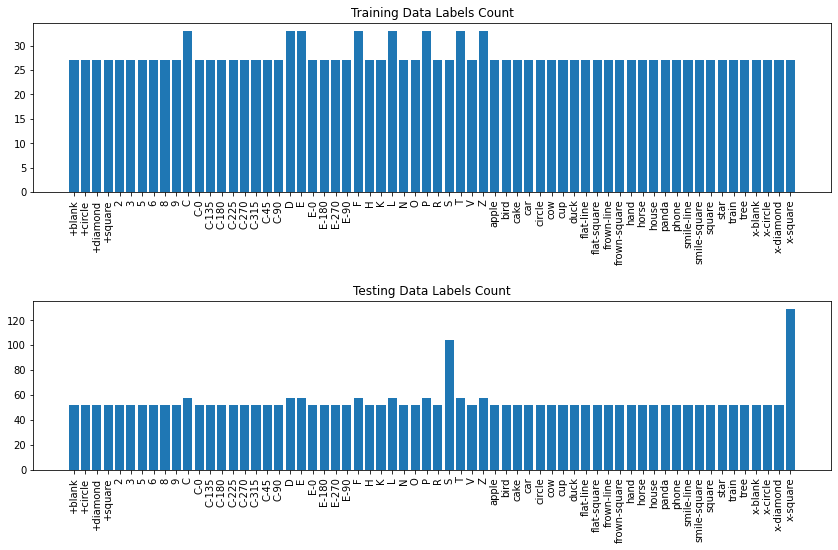

In [32]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec



fig = plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(2, 1, figure=fig)
# Display original image
plt.subplot(gs[0]) 
plt.bar(sorted_labels, num_training) 
plt.xticks(rotation='vertical')
plt.title("Training Data Labels Count")

plt.subplot(gs[1]) 
plt.bar(sorted_labels, num_testing) 
plt.xticks(rotation='vertical')
plt.title("Testing Data Labels Count")

fig.tight_layout(pad=2.0)
plt.show()

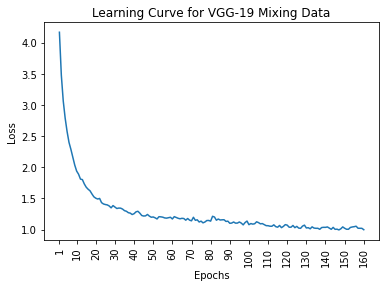

In [44]:
epochs = [i + 1 for i in range(160)]
epoch_ticks = [i for i in range(0, 165, 10)] 
epoch_ticks[0] = 1
loss = [4.1646, 3.4758, 3.0628, 2.7875, 2.5740, 2.3994, 2.2869, 
        2.1616, 2.0360, 1.9389, 1.8888, 1.8101, 1.8023, 1.7326, 
        1.6805, 1.6478, 1.6221, 1.5718, 1.5264, 1.5041, 1.4911, 
        1.5003, 1.4334, 1.4118, 1.4026, 1.3967, 1.3798, 1.3495, 
        1.3858, 1.3623, 1.3389, 1.3460, 1.3444, 1.3294, 1.3045, 
        1.2945, 1.2719, 1.2648, 1.2422, 1.2557, 1.2853, 1.2947, 
        1.2644, 1.2268, 1.2182, 1.2210, 1.2435, 1.2164, 1.1990, 
        1.2033, 1.1895, 1.1715, 1.2077, 1.2052, 1.1999, 1.1878, 
        1.1845, 1.1917, 1.1985, 1.1712, 1.2085, 1.1946, 1.1824, 
        1.1741, 1.1817, 1.1783, 1.1517, 1.1786, 1.1521, 1.1417, 
        1.1986, 1.1500, 1.1575, 1.1227, 1.1362, 1.1091, 1.1224, 
        1.1463, 1.1472, 1.1364, 1.2143,  1.2024, 1.1514, 1.1705, 
        1.1545, 1.1578, 1.1589, 1.1318, 1.1359, 1.1021, 1.1055, 
        1.1229, 1.1043, 1.1053, 1.1230, 1.1050, 1.0767, 1.1140, 
        1.1376, 1.0799, 1.0976, 1.0886, 1.0946, 1.1256, 1.1131, 
        1.0932, 1.0972, 1.0810, 1.0642, 1.0631, 1.0551, 1.0547, 
        1.0772, 1.0483, 1.0390, 1.0671, 1.0320, 1.0524, 1.0806, 
        1.0723, 1.0394, 1.0394, 1.0671, 1.0317, 1.0525, 1.0246, 
        1.0214, 1.0567, 1.0724, 1.0269, 1.0312, 1.0134, 1.0449, 
        1.0254, 1.0215, 1.0219, 1.0058, 1.0338, 1.0373, 1.0367, 
        1.0435, 1.0249, 1.0056, 1.0364, 1.0052, 1.0079, 0.9957, 
        1.0133, 1.0441, 1.0222, 1.0064, 1.0062, 1.0354, 1.0430, 
        1.0476, 1.0552, 1.0225, 1.0222, 1.0212, 0.9990]

# Graphs the learning curve
plt.plot(epochs, loss)
plt.title("Learning Curve for VGG-19 Mixing Data")
plt.xticks(epoch_ticks, rotation='vertical')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

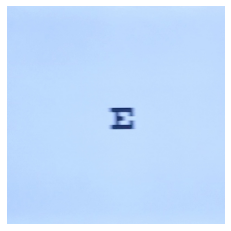

Predict: +blank
Truth label: K


In [75]:
import numpy as np
img = plt.imread(training_dir + '/E/0-3-90.Png')
plt.imshow(img)
plt.axis('off')
plt.show()
img = img.reshape(1, 400, 400, 3)
print("Predict: " + labels[np.argmax(np.array(model.predict(img)))])
print("Truth label: K")